In [76]:
import pandas as pd

In [77]:
reddit = pd.read_csv("datasets/upvotes.csv")
reddit.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [78]:
reddit.shape

(330045, 7)

In [79]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          330045 non-null  int64  
 1   Tag         330045 non-null  object 
 2   Reputation  330045 non-null  float64
 3   Answers     330045 non-null  float64
 4   Username    330045 non-null  int64  
 5   Views       330045 non-null  float64
 6   Upvotes     330045 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [80]:
reddit = reddit.dropna()

In [81]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330045 entries, 0 to 330044
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          330045 non-null  int64  
 1   Tag         330045 non-null  object 
 2   Reputation  330045 non-null  float64
 3   Answers     330045 non-null  float64
 4   Username    330045 non-null  int64  
 5   Views       330045 non-null  float64
 6   Upvotes     330045 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 20.1+ MB


In [82]:
reddit['Tag'].value_counts()

c    72458
j    72232
p    43407
i    32400
a    31695
s    23323
h    20564
o    14546
r    12442
x     6978
Name: Tag, dtype: int64

### Going to one hot encode the above values

In [83]:
from sklearn.preprocessing import OneHotEncoder
ohEncoder = OneHotEncoder()
tag_cat = reddit[["Tag"]]
tags = ohEncoder.fit_transform(tag_cat)
tags

<330045x10 sparse matrix of type '<class 'numpy.float64'>'
	with 330045 stored elements in Compressed Sparse Row format>

In [84]:
tags.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
ohEncoder.categories_

[array(['a', 'c', 'h', 'i', 'j', 'o', 'p', 'r', 's', 'x'], dtype=object)]

### transforming to add new column that shows the views ratioed by the reputation

In [86]:
import sklearn
import numpy as np
# Going to use the apply function similar to the transform function

#make sure no reputation values are zero so division by zero will not happen
reddit = reddit[reddit.Reputation != 0]
reddit['ViewsPerPop'] = reddit.apply(lambda row : row.Views / row.Reputation, axis = 1)
reddit.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,ViewsPerPop
0,52664,a,3942.0,2.0,155623,7855.0,42.0,1.992643
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,2.142402
2,468453,c,1358.0,4.0,56177,8067.0,60.0,5.940353
3,96996,a,264.0,3.0,168793,27064.0,9.0,102.515152
4,131465,c,4271.0,4.0,112223,13986.0,83.0,3.274643


### using ensemble methods to get a predictor for upvotes

[source](https://www.geeksforgeeks.org/ensemble-methods-in-python/)

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

reddit = pd.read_csv("datasets/upvotes.csv")

reddit = reddit[reddit.Upvotes != 0]

reddit = reddit.head(500)
print(reddit.shape)

reddit = reddit[reddit.Reputation != 0]
reddit['ViewsPerPop'] = reddit.apply(lambda row : row.Views / row.Reputation, axis = 1)

reddit = reddit.drop(['Username', 'ID', 'Answers'], axis=1)

reddit = pd.get_dummies(reddit)
upvotes = np.array(reddit['Upvotes'])

reddit = reddit.drop(['Upvotes'], axis=1)

reddit_list = list(reddit.columns)

reddit = np.array(reddit)

train_reddit, test_reddit, train_upvotes, test_upvotes = train_test_split(reddit, upvotes, test_size = 0.25, random_state = 42)

rf1 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf1.fit(train_reddit, train_upvotes)
rf1_pred = rf1.predict(test_reddit)

rf2 = LinearRegression()
rf2.fit(train_reddit, train_upvotes)
rf2_pred = rf2.predict(test_reddit)

rf3 = KNeighborsClassifier(n_neighbors=9)
rf3.fit(train_reddit, train_upvotes)
rf3_pred = rf3.predict(test_reddit)

#get the average of the three models for the ensemble model
eavg = (rf1_pred + rf2_pred + rf3_pred)/3

#print error
print("ensamble mean squared error:", sklearn.metrics.mean_squared_error(test_upvotes, eavg))
print('thats a lot of error, this predicted data is awful')


(500, 7)
ensamble mean squared error: 636669.9234495836
thats a lot of error, this predicted data is awful


### simple start to prediction pipeline rand. forest
[followed this example](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)

edit: not too happy with the accuracy so lets attempt a pipeline for linear regression

In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

reddit = pd.read_csv("datasets/upvotes.csv")

#realizing shape makes this take forever
# print(reddit.shape)
reddit = reddit[reddit.Upvotes != 0]
# reddit = reddit[reddit.Answers != 0]
# reddit = reddit[reddit.Reputation != 0]

reddit = reddit.head(10000)
print(reddit.shape)

reddit = reddit[reddit.Reputation != 0]
reddit['ViewsPerPop'] = reddit.apply(lambda row : row.Views / row.Reputation, axis = 1)

reddit = reddit.drop(['Username', 'ID', 'Answers'], axis=1)

reddit = pd.get_dummies(reddit)
upvotes = np.array(reddit['Upvotes'])

reddit = reddit.drop(['Upvotes'], axis=1)

reddit_list = list(reddit.columns)

reddit = np.array(reddit)

train_reddit, test_reddit, train_upvotes, test_upvotes = train_test_split(reddit, upvotes, test_size = 0.25, random_state = 42)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_reddit, train_upvotes)

# Use the forest's predict method on the test data
predictions = rf.predict(test_reddit)

# Calculate the absolute errors
errors = abs(predictions - test_upvotes)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_upvotes)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

(10000, 7)
Mean Absolute Error: 152.81 degrees.
Accuracy: -33.09 %.


### simple start to prediction pipeline linear
this one is not much better. this data may just suck

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

reddit = pd.read_csv("datasets/upvotes.csv")

#realizing shape makes this take forever
# print(reddit.shape)
reddit = reddit[reddit.Upvotes != 0]
# reddit = reddit[reddit.Answers != 0]
# reddit = reddit[reddit.Reputation != 0]

reddit = reddit.head(10000)
print(reddit.shape)

reddit = reddit[reddit.Reputation != 0]
reddit['ViewsPerPop'] = reddit.apply(lambda row : row.Views / row.Reputation, axis = 1)

reddit = reddit.drop(['Username', 'ID', 'Answers'], axis=1)

reddit = pd.get_dummies(reddit)
upvotes = np.array(reddit['Upvotes'])

reddit = reddit.drop(['Upvotes'], axis=1)

reddit_list = list(reddit.columns)

reddit = np.array(reddit)

train_reddit, test_reddit, train_upvotes, test_upvotes = train_test_split(reddit, upvotes, test_size = 0.25, random_state = 42)

rf = LinearRegression()
rf.fit(train_reddit, train_upvotes)

#coefficient of determination
print('coefficient of determination:', rf.score(train_reddit, train_upvotes))

(10000, 7)
coefficient of determination: 0.37474032124673706


### going to try to pipeline with SGDClassifier
beginning to think these just have awful accuracy for predictions

In [90]:
#pipeline for SGDClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

reddit = pd.read_csv("datasets/upvotes.csv")

#realizing shape makes this take forever
# print(reddit.shape)
reddit = reddit[reddit.Upvotes != 0]
# reddit = reddit[reddit.Answers != 0]
# reddit = reddit[reddit.Reputation != 0]

reddit = reddit.head(300)
print(reddit.shape)

reddit = reddit[reddit.Reputation != 0]
reddit['ViewsPerPop'] = reddit.apply(lambda row : row.Views / row.Reputation, axis = 1)

reddit = reddit.drop(['Username', 'ID', 'Answers'], axis=1)

reddit = pd.get_dummies(reddit)
upvotes = np.array(reddit['Upvotes'])

reddit = reddit.drop(['Upvotes'], axis=1)

reddit_list = list(reddit.columns)

reddit = np.array(reddit)

train_reddit, test_reddit, train_upvotes, test_upvotes = train_test_split(reddit, upvotes, test_size = 0.25, random_state = 42)

rf = SGDClassifier(random_state=42, max_iter=1000)
rf.fit(train_reddit, train_upvotes)

y_pred = rf.predict(test_reddit)
print("Accuracy: ",accuracy_score(test_upvotes, y_pred))

(300, 7)
Accuracy:  0.013333333333333334


### going to try to pipeline with KNeighborsClassifier

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

reddit = pd.read_csv("datasets/upvotes.csv")

#realizing shape makes this take forever
# print(reddit.shape)
reddit = reddit[reddit.Upvotes != 0]
# reddit = reddit[reddit.Answers != 0]
# reddit = reddit[reddit.Reputation != 0]

reddit = reddit.head(300)
print(reddit.shape)

reddit = reddit[reddit.Reputation != 0]
reddit['ViewsPerPop'] = reddit.apply(lambda row : row.Views / row.Reputation, axis = 1)

reddit = reddit.drop(['Username', 'ID', 'Answers'], axis=1)

reddit = pd.get_dummies(reddit)
upvotes = np.array(reddit['Upvotes'])

reddit = reddit.drop(['Upvotes'], axis=1)

reddit_list = list(reddit.columns)

reddit = np.array(reddit)

train_reddit, test_reddit, train_upvotes, test_upvotes = train_test_split(reddit, upvotes, test_size = 0.25, random_state = 42)

rf = KNeighborsClassifier(n_neighbors=9)
rf.fit(train_reddit, train_upvotes)

guess_upvotes = rf.predict(test_reddit)
print("Accuracy: ",accuracy_score(test_upvotes, guess_upvotes))

(300, 7)
Accuracy:  0.05333333333333334


### Confusion Matrix

In [92]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_upvotes, y_pred)
conf_matrix

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### OvR Classifier

In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.multiclass import OneVsRestClassifier

reddit = pd.read_csv("datasets/upvotes.csv")

reddit = reddit[reddit.Upvotes != 0]

reddit = reddit.head(500)
print(reddit.shape)

reddit = reddit[reddit.Reputation != 0]
reddit['ViewsPerPop'] = reddit.apply(lambda row : row.Views / row.Reputation, axis = 1)

reddit = reddit.drop(['Username', 'ID', 'Answers'], axis=1)

reddit = pd.get_dummies(reddit)
upvotes = np.array(reddit['Upvotes'])

reddit_ups = reddit['Upvotes']
reddit = reddit.drop(['Upvotes'], axis=1)

reddit_list = list(reddit.columns)

reddit = np.array(reddit)

train_reddit, test_reddit, train_upvotes, test_upvotes = train_test_split(reddit, upvotes, test_size = 0.25, random_state = 42)

ovr = OneVsRestClassifier(SGDClassifier())
ovr.fit(train_reddit, train_upvotes)

guess_upvotes = ovr.predict(test_reddit)
print("Accuracy: ",accuracy_score(test_upvotes, guess_upvotes))

(500, 7)
Accuracy:  0.016129032258064516


### ROC Curve

In [116]:
from sklearn.model_selection import cross_val_predict

train_reddit, test_reddit, train_upvotes, test_upvotes = train_test_split(reddit, upvotes, test_size = 0.25, random_state = 42)
sgd_clf = SGDClassifier(random_state=42)
scores = cross_val_predict(sgd_clf, train_reddit, train_upvotes, cv=3)

roc_scores = scores[:124]
preds = guess_upvotes

fpr, tpr, thresholds = roc_curve(preds, roc_scores, pos_label=1)

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


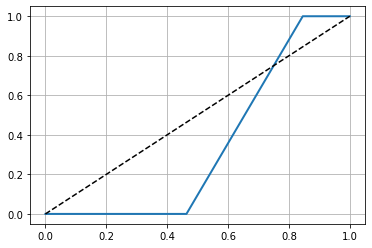

In [117]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()